In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier

In [2]:
#load csv's to dataframes
adv_df = pd.read_csv('advanced_stats.csv')
per_game_df = pd.read_csv('per_game_stats.csv')
stripped_pg_df = per_game_df.drop(columns=['Rk', 'Tm', 'Pos', 'G', 'MP'])
dataframe = adv_df.merge(stripped_pg_df, on = ['Player','Year'], how = 'outer')
dataframe.to_csv('all_stats.csv', index=False)

In [3]:
#globals
OWS_centers = []
OWS_point_guards = []
OWS_sforwards = []
OWS_pforwards = []
years = []

OWS_shooting_guards = []

DWS_centers = []
DWS_pgs = []

In [4]:
#create WS information from dataframes
year = 1955
while year <= 2016:
    centers = dataframe[(dataframe['Year'] == year) & (dataframe['Pos'].str.contains('C'))]
    point_guards = dataframe[(dataframe['Year'] == year) & (dataframe['Pos'].str.contains('PG'))]
    shooting_guards = dataframe[(dataframe['Year'] == year) & (dataframe['Pos'].str.contains('SG'))]
    small_forwards = dataframe[(dataframe['Year'] == year) & (dataframe['Pos'].str.contains('SF'))]
    power_forwards = dataframe[(dataframe['Year'] == year) & (dataframe['Pos'].str.contains('PF'))]

    #calculate average OWS among top WS players 
    sample_size = 10
    rating = 'WS'
    top_centers = centers.nlargest(sample_size, rating)
    top_pgs = point_guards.nlargest(sample_size, rating)

    center_ave_OWS = top_centers['OWS'].sum()/sample_size
    point_guard_ave_OWS = top_pgs['OWS'].sum()/sample_size
    OWS_centers.append(center_ave_OWS)
    OWS_point_guards.append(point_guard_ave_OWS)

    #calculate average DWS among top WS players
    top_centers = centers.nlargest(sample_size, rating)
    top_pgs = point_guards.nlargest(sample_size, rating)
    
    center_ave_DWS = top_centers['DWS'].sum()/sample_size
    point_guard_ave_DWS = top_pgs['DWS'].sum()/sample_size
    DWS_centers.append(center_ave_DWS)
    DWS_pgs.append(point_guard_ave_DWS)
    
    years.append(year)
    year += 1

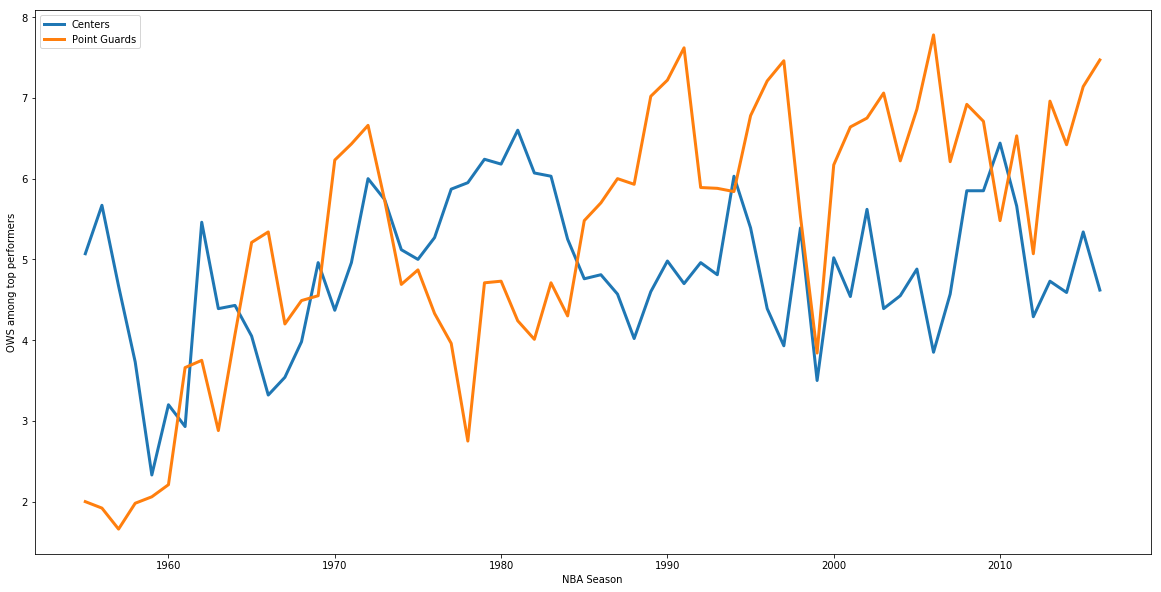

In [5]:
#plot year vs OWS among top players
mpl.rcParams['figure.figsize'] = (20,10)
plt.plot(years, OWS_centers, label="Centers", linewidth=3)
plt.plot(years, OWS_point_guards, label="Point Guards", linewidth=3)

plt.xlabel("NBA Season")
plt.ylabel("OWS among top performers")
plt.legend(loc=2)

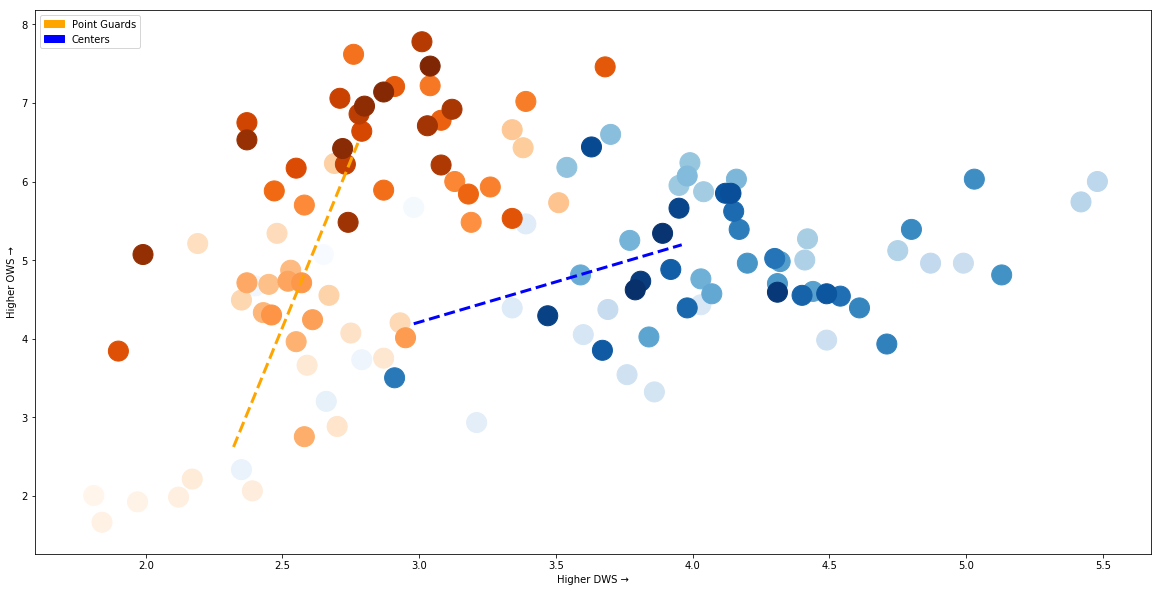

*Faded points are older seasons, opaque points are more recent seasons


In [18]:
#plot DWS vs OWS among top performers
plt.scatter(DWS_centers, OWS_centers, s=400, cmap="Blues", c=years, label="Centers")
plt.scatter(DWS_pgs,OWS_point_guards, s=400, cmap="Oranges", c=years, label="Point Guards")
plt.xlabel("Higher DWS →")
plt.ylabel("Higher OWS →")

#simple trendlines
c_x1 = sum(DWS_centers[:10])/10 #first 10
c_y1 = sum(OWS_centers[:10])/10
c_x2 = sum(DWS_centers[-10:])/10 #last 10
c_y2 = sum(OWS_centers[-10:])/10

pg_x1 = sum(DWS_pgs[:10])/10
pg_y1 = sum(OWS_point_guards[:10])/10
pg_x2 = sum(DWS_pgs[-10:])/10
pg_y2 = sum(OWS_point_guards[-10:])/10

plt.plot([c_x1, c_x2], [c_y1, c_y2], '--', color="blue", linewidth=3)
plt.plot([pg_x1, pg_x2], [pg_y1, pg_y2], '--', color="orange", linewidth=3)

#create legend
orange_patch = mpatches.Patch(color='orange', label='Point Guards')
blue_patch = mpatches.Patch(color='blue', label='Centers')
plt.legend(handles=[orange_patch, blue_patch], loc=2)
plt.show()
print("*Faded points are older seasons, opaque points are more recent seasons")


In [7]:
#neural network for classifying player by position

#create and train classifier for 2013-2016
classifier = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(2000,1000))
dataset = dataframe[(dataframe['Year'] <= 2016) & (dataframe['Year'] >= 2013)].drop(columns=['Rk', 'Tm', 'G', 'MP','Year']).dropna(axis=1, how='any')
labels = dataset['Pos']
classifier.fit(dataset.drop(columns=['Pos','Player']), labels)

#make predictions for 2017
testing_df = dataframe[dataframe['Year'] == 2015].drop(columns=['Rk', 'Tm', 'G', 'MP','Year','PER','ORB%','DRB%', 'TRB%','AST%', 'STL%','BLK%','USG%','WS/48']).dropna(axis=1, how='any')
correct = 0
count = 0
for i, row in testing_df.iterrows():
    player = row.drop(['Pos','Player'])
    if(classifier.predict([player]) == testing_df.loc[i,'Pos']):
        correct += 1
    count += 1

print("Correct %: " , correct/count)

Correct %:  0.6747967479674797
